# Gamified Biometric Data Notebook

Created by Liz Beard on 20240724
Last updated on 20240724

In [36]:
# let's load our libraries
import pandas as pd
import os
import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from scipy.ndimage import gaussian_filter
import scipy.stats as stats
from skimage.transform import resize
import statsmodels.api as sm
from statsmodels.stats.anova import AnovaRM
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import ttest_rel
import seaborn as sns

# Data Wrangling/Cleaning

**Sensor Data CSV**

(pulled from [iMotions documentation](https://help.imotions.com/docs/export-sensor-data#the-format-colorcoded))
| Rows | Section | Description|
|----|----|----|
|1-18|INFO|general information about the recorded data (e.g. name of the study, name of the respondent, recording time, information about the hardware systems used, etc.)|
|19-31|METADATA|provides, for each of the data-columns in the export-file, explanatory information about the data contained in the respective data-columns (e.g., where the data comes from, the category of data, a short description of the data, the unit, etc.)|
|32+|DATA| contains the sensor data, but also other types of data (e.g., 'events').|

Data Columns:
| Column | Data Type | Description |
|----|----|----|
|Row|Timeline|Simple row index|
|Timestamp|Timeline|Elapsed time since the recording start (in milliseconds)|
|Eventsource|Slideshow events|Boolean which marks slide events (1 = slide event)|
|StartSlide|Slideshow events|start command is forwarded by iMotions to the media player|
|StartMedia|Slideshow events|confirmaton from the media player that the slide has started|
|EndMedia|Slideshow events|confirmation from the media player that the slide has ended|
|EndSlide|Slideshow events|end command is executed by iMotions|
|StimType|Slideshow events|allegedly unimportant?|
|Duration|Slideshow events|Planned duration of the slides (in milliseconds)|
|CollectionPhase|Slideshow events|allegedly unimportant?|
|SourceStimuliName|Slideshow events|User-defined name of the slide|
|Event Source|Sensor data|Boolean which marks data-samples recorded from a given device (1 = data sample)|
|Sensor Data Columns|Sensor data|Data output from a given sensor. Note that post-imported data, unknown data received by iMotions over the API, or R-processed 'continuous' data (e.g., filtered data) are represented in the same way as the sensor data provided directly by the hardware systems.|

In [2]:
# directories
data_dir = os.path.abspath(os.path.join(os.getcwd(), '../summer-2024/iMotions'))

## Separate Main CSV, Organize Files

In [ ]:
def separate_data_by_device(metadata_section, data_section, output_dir, subj=None, block=None):
    # Identify Row and Timestamp columns by their descriptions
    row_col_name = data_section.columns[0]  # Typically the first column
    timestamp_col_name = data_section.columns[1]  # Typically the second column
    
    # Extract device names from the metadata section
    metadata_devices = metadata_section.iloc[1, 1:].dropna().unique()
    
    # Create a directory to save the device-specific CSV files
    os.makedirs(output_dir, exist_ok=True)
    
    # Process each device and save the relevant data to a separate CSV file
    for device in metadata_devices:
        device_columns = metadata_section.columns[metadata_section.iloc[1] == device].tolist()
        columns_to_include = [row_col_name, timestamp_col_name] + device_columns
        
        # Filter the data section for the current device
        device_data = data_section.iloc[1:, columns_to_include]
        
        # Save to CSV
        if subj and block is not None:
            filename = f'{subj}_block-{block}_{device}.csv'
        else:
            filename = f'{device}.csv'
            
        device_file_path = os.path.join(output_dir, filename)
        device_data.to_csv(device_file_path, index=False, header=False)

    
    print(f'Data separated by devices and saved to {output_dir}')

In [ ]:
subj_csvs = sorted(glob.glob(os.path.join(data_dir, 'exported', 'Gamified Images - Block [0-7]', 'Sensor Data', '*.csv')))

In [ ]:
for data in subj_csvs:
    block = data.split('/')[-3].split(' ')[-1]
    subj = data.split('/')[-1].split('_')[-1].split('.')[0]

    print('Sorting ',subj, ', block ', block)

    data = pd.read_csv(data, header=None, dtype=str)
    
    if not isinstance(data, pd.DataFrame):
        raise ValueError("data is not a pandas DataFrame")

    # Create a directory to save the specific CSV files
    save_dir = os.path.join(data_dir, subj)
    os.makedirs(save_dir, exist_ok=True)

    # Identify the starting indices of each section
    info_start_idx = 0
    metadata_start_idx = data[data.iloc[:, 0].str.contains('#METADATA', na=False)].index[0]
    data_start_idx = data[data.iloc[:, 0].str.contains('#DATA', na=False)].index[0]

    # Extract each section
    info_section = data.iloc[info_start_idx:metadata_start_idx]
    metadata_section = data.iloc[metadata_start_idx:data_start_idx]
    data_section = data.iloc[data_start_idx:]

    # Return file paths for verification
    info_file_path = os.path.join(save_dir, f'{subj}_block-{block}_INFO.csv')
    metadata_file_path = os.path.join(save_dir,f'{subj}_block-{block}_METADATA.csv')
    data_file_path = os.path.join(save_dir, f'{subj}_block-{block}_DATA.csv')

    # Save each section to separate CSV files
    info_section.to_csv(info_file_path, index=False, header=False)
    metadata_section.to_csv(metadata_file_path, index=False, header=False)
    data_section.to_csv(data_file_path, index=False, header=False)

    # Call the function
    separate_data_by_device(metadata_section, data_section, save_dir, subj, block)

## Combine PsychoPy CSVS into Single Subj File

In [ ]:
psychopy_dir = os.path.abspath(os.path.join(os.getcwd(), '../summer-2024/tasks/logs'))
subj_dirs = sorted(glob.glob(os.path.join(psychopy_dir, 'sub-0[0-6]*')))
psychopy_file_pattern = '{}_block-[0-7].csv'

for dir in subj_dirs:
    subj = dir.split('/')[-1]

    # Read and concatenate the CSV files that match the psychopy file pattern for the given subj
    subj_files = sorted(glob.glob(os.path.join(dir, psychopy_file_pattern.format(subj))))

    data_frames = []

    for file in subj_files:

        # Extract block number from the filename
        block_number = file.split('/')[-1].split('_')[-1].split('-')[-1][-5]
        df = pd.read_csv(file)
        df['block'] = block_number  # Add block number as a new column
        data_frames.append(df)
    
    subj_data = pd.concat(data_frames)
    
    # save the concatenated data
    subj_data.to_csv(os.path.join(data_dir, subj, f'{subj}_psychopy.csv'), index=False)


## Create PsychoPy Screen for correct gaze mapping

In [ ]:
def recreate_screen(image_path, output_path, window_size=(1920, 1080), background_color=(128, 128, 128)):
    """
    Recreates a screen with the specified image centered on a background of the given color and size.

    Parameters:
    - image_path (str): Path to the input image.
    - output_path (str): Path to save the recreated screen image.
    - window_size (tuple): Size of the window (width, height). Default is (1290, 1080).
    - background_color (tuple): Background color in RGB. Default is (0, 0, 0).
    """
    # Load the image
    image = Image.open(image_path)

    # Create a new image with the specified background color
    screen = Image.new('RGB', window_size, background_color)

    # Calculate the position to center the image on the screen
    image_position = (
        (window_size[0] - image.width) // 2,
        (window_size[1] - image.height) // 2
    )

    # Paste the image onto the screen at the calculated position
    screen.paste(image, image_position)

    # Save the recreated screen as an image file
    screen.save(output_path)

    print(f'Recreated screen saved to {output_path}')

In [ ]:
# test usage
image_id = '2512' # eventually i'll want to loop through all of the images and make sure the image is just the prefix (not the .jpg)
images_path = os.path.abspath(os.path.join(os.getcwd(), f'../summer-2024/tasks/study1-images_v1-20240602/'))

recreate_screen(os.path.join(images_path, f'{image_id}.jpg'), f'/Users/ebeard/Downloads/{image_id}-Dell.jpg')

In [ ]:
dell_dir = os.path.join(data_dir, 'screen')

for image in sorted(glob.glob(images_path + '/*.jpg')):
    image_id = image.split('/')[-1].split('.')[0]
    recreate_screen(image, os.path.join(dell_dir, f'{image_id}-screen.jpg'))

# Heatmaps
Tbh I'm not entirely sure why I wanted to separate all the data when I could just work out of the DATA spreadsheet. Shrug.


Using technique described by [pupil labs](https://docs.pupil-labs.com/neon/pupil-cloud/visualizations/heatmap/).

In [3]:
# Define the function to get fixation data between onset and offset
def get_fixation_data_between_onset_offset(events_df, gaze_df, image_id):
    # Filter events for the specific image onset and offset
    image_events = events_df[events_df['MarkerName'] == f'{image_id}.jpg']
    
    # Find the onset and offset timestamps
    onset_timestamp = image_events[image_events['MarkerDescription'].str.contains('onset', na=False)]['Timestamp']
    offset_timestamp = image_events[image_events['MarkerDescription'].str.contains('offset', na=False)]['Timestamp']
    
    # Ensure we have exactly one onset and one offset timestamp
    if len(onset_timestamp) != 1 or len(offset_timestamp) != 1:
        raise ValueError("Expected exactly one onset and one offset timestamp for the image.")
    
    # Extract scalar values from the Series
    onset_timestamp = onset_timestamp.iloc[0]
    offset_timestamp = offset_timestamp.iloc[0]
    
    # Filter gaze data between onset and offset
    fixation_data = gaze_df[(gaze_df['Timestamp'] >= onset_timestamp) & (gaze_df['Timestamp'] <= offset_timestamp)]
    
    return fixation_data

In [ ]:
def create_heatmap(stimulus_eye_data, image_path, output_path,image_size=(1920, 1080), sampling_rate=30):
    # Convert fixation data to numpy arrays
    fixation_x = stimulus_eye_data['Fixation X'].values
    fixation_y = stimulus_eye_data['Fixation Y'].values
    event_duration = stimulus_eye_data['Fixation Duration'].values

    # Upsample for kernel density estimation
    x_samples = np.repeat(fixation_x, (event_duration * sampling_rate / 1000).astype(int))
    y_samples = np.repeat(fixation_y, (event_duration * sampling_rate / 1000).astype(int))

    # Perform 2D kernel density estimation
    kde = stats.gaussian_kde(np.vstack([x_samples, y_samples]), bw_method='scott')
    x_grid = np.linspace(0, image_size[0], 300)
    y_grid = np.linspace(0, image_size[1], 300)
    x_mesh, y_mesh = np.meshgrid(x_grid, y_grid)
    grid_coords = np.vstack([x_mesh.ravel(), y_mesh.ravel()])
    kde_values = kde(grid_coords).reshape(x_mesh.shape)

    # Normalize the kde values to the maximum
    kde_values /= kde_values.max()

    # Define heatmap colors
    heatmap_colors = ['#FFFFFF00', '#00FF007A', '#48FF007A', '#91FF007A', '#DAFF007A', 
                      '#FFDA007A', '#FF91007A', '#FF48007A', '#FF00007A']
    cmap = ListedColormap(heatmap_colors)

    # load the sample image
    screen_image = Image.open(image_path).convert('RGBA')

        # Create a figure and plot
    fig, ax = plt.subplots()
    ax.imshow(screen_image, extent=(0, image_size[0], image_size[1], 0))
    ax.imshow(kde_values, cmap=cmap, extent=(0, image_size[0], image_size[1], 0), aspect='equal', origin='upper', alpha=0.8)
    ax.set_xlim(0, image_size[0])
    ax.set_ylim(image_size[1], 0)
    ax.axis('off')  # Turn off the axis

    # Save the figure
    plt.savefig(output_path, format='PNG', bbox_inches='tight', pad_inches=0)
    plt.close(fig)

    print(f'Heatmap image saved to {output_path}')

    # heatmap_image = Image.fromarray(np.uint8(plt.cm.hot(kde_values) * 255))

    # # Blend the heatmap with the original image
    # blended_image = Image.blend(screen_image, heatmap_image.resize(screen_image.size).convert('RGBA'), alpha=0.5)

    # # Display the blended image
    # blended_image.save(output_path, format='PNG')

    # print(f'Blended image saved to {output_path}')


In [ ]:
# we need to add all subjects fixations for a given stimuli
subj_dirs = sorted(glob.glob(os.path.join(data_dir, 'sub-*')))
all_stimuli = pd.read_csv(os.path.join('/Users/ebeard/Dropbox (Penn)/gamified/summer-2024/tasks/image-list_v3-20240618.csv'))
stim_list = list(all_stimuli['IAPS Source file'])+list(all_stimuli['Game6 - Black and White'])+list(all_stimuli['Game2 - Cartoon style#1'])
screen_path = os.path.join(data_dir, 'screen')
output_dir = os.path.join(data_dir, 'heatmaps', 'matplotlib')

heatmap_info = {'image_id': [], 'num_subjs': [], 'num_fixations': []}
heatmap_df = []

for stim in stim_list:

    print(f'Generating heatmap for {stim}...')
    image_id = stim.split('.')[0]
    heatmap_info['image_id'].append(image_id)

    all_fixation_data = []

    for x in subj_dirs:
        subj = x.split('/')[-1]

        # # need to find correct subj ET data path from the sub-001_psychopy.csv folder
        psychopy_csv = pd.read_csv(os.path.join(x, f'{subj}_psychopy.csv'))

        try:

            block = psychopy_csv['block'].loc[psychopy_csv['image_file']==f'{image_id}.jpg']
            
            if block.empty:
                print(f"No block found for image_id {image_id} for {subj}")
                continue

            block = block.iloc[0]

            # # Check if block is a single digit
            if len(str(block)) != 1:
                print("Block is not a single digit.")

            # # load the data for the correct events and gaze file
            # print(f'Loading data for {subj} block {block}...')
            events_df = pd.read_csv(os.path.join(x, f'{subj}_block-{block}_External Events API (v0).csv'))
            gaze_df = pd.read_csv(os.path.join(x, f'{subj}_block-{block}_R Analysis GazeAnalysis I-VT filter.csv'))

            # # Get fixation data for the specific image
            fixation_data = get_fixation_data_between_onset_offset(events_df, gaze_df, image_id)
            valid_fixations = fixation_data.dropna(subset=['Fixation X', 'Fixation Y', 'Fixation Duration']).copy()
            valid_fixations = valid_fixations.drop_duplicates(subset=['Fixation X', 'Fixation Y', 'Fixation Duration']).dropna(axis=1)

            # # Drop the first fixation
            valid_fixations = valid_fixations.iloc[1:]

            # # add subj and image_id to the dataframe
            valid_fixations['subj'] = subj
            valid_fixations['image_id'] = f'{image_id}.jpg'
            valid_fixations['block'] = block

            # # append to all_fixation_data
            all_fixation_data.append(valid_fixations)
        
        except Exception as e:
            print(f"An error occurred while processing {subj} block {block}: {e}")
            continue
    try:

        screen_image_path = os.path.join(screen_path, f'{image_id}-screen.jpg')
        output_path = os.path.join(output_dir, f'{image_id}-heatmap.png')

        all_fixation_data = pd.concat(all_fixation_data)
        heatmap_info['num_subjs'].append(all_fixation_data['subj'].nunique())
        heatmap_info['num_fixations'].append(len(all_fixation_data))
        heatmap_df.append(all_fixation_data)
        create_heatmap(all_fixation_data, screen_image_path, output_path, image_size=(1920, 1080), sampling_rate=30)
    except Exception as e:
        print(f"An error occurred while processing {image_id}: {e}")
        continue

heatmap_info_df = pd.DataFrame(heatmap_info)
heatmap_info_df.to_csv(os.path.join(output_dir, 'heatmap_info.csv'), index=False)
heatmap_df = pd.concat(heatmap_df)
heatmap_df.to_csv(os.path.join(output_dir, 'heatmap_data.csv'), index=False)

# First Fixation
First fixation after the initial saccade.

We can use the `get_fixation_data_between_onset_offset` function to find the fixation data then filter out with the initial saccade.

In [5]:
subj_dirs = sorted(glob.glob(os.path.join(data_dir, 'sub-*')))
all_stimuli = pd.read_csv(os.path.join('/Users/ebeard/Dropbox (Penn)/gamified/summer-2024/tasks/image-list_v3-20240618.csv'))
stim_list = list(all_stimuli['IAPS Source file'])+list(all_stimuli['Game6 - Black and White'])+list(all_stimuli['Game2 - Cartoon style#1'])
screen_path = os.path.join(data_dir, 'screen')

In [20]:
first_fixation_df = []

for stim in stim_list[:]:

    print(f'Aggregating first fixation data for {stim}...')
    image_id = stim.split('.')[0]

    for x in subj_dirs[:]:

        subj = x.split('/')[-1]

        # # need to find correct subj ET data path from the sub-001_psychopy.csv folder
        psychopy_csv = pd.read_csv(os.path.join(x, f'{subj}_psychopy.csv'))

        try:

            block = psychopy_csv['block'].loc[psychopy_csv['image_file']==f'{image_id}.jpg']
            
            if block.empty:
                print(f"No block found for image_id {image_id} for {subj}")
                continue

            block = block.iloc[0]

            # # Check if block is a single digit
            if len(str(block)) != 1:
                print("Block is not a single digit.")

            # # load the data for the correct events and gaze file
            # print(f'Loading data for {subj} block {block}...')
            events_df = pd.read_csv(os.path.join(x, f'{subj}_block-{block}_External Events API (v0).csv'))
            gaze_df = pd.read_csv(os.path.join(x, f'{subj}_block-{block}_R Analysis GazeAnalysis I-VT filter.csv'))

            # # Get fixation data for the specific image
            fixation_data = get_fixation_data_between_onset_offset(events_df, gaze_df, image_id)

            # # select fixation after first saccade
            first_saccade = fixation_data[fixation_data['Saccade Index'].notna()].iloc[0]
            fixation_data_after_saccade = fixation_data[fixation_data['Timestamp'] > first_saccade['Saccade End']]
            fixation_data_after_saccade = fixation_data_after_saccade.dropna(subset=['Fixation X', 'Fixation Y', 'Fixation Duration']).copy()
            fixation_data_after_saccade = fixation_data_after_saccade.drop_duplicates(subset=['Fixation X', 'Fixation Y', 'Fixation Duration']).dropna(axis=1)

            # first fixation after saccade
            first_fixation = fixation_data_after_saccade.iloc[[0]].copy()
            trial_onset = fixation_data['Timestamp'].iloc[0] # trial immedately after onset
            first_fixation.loc[first_fixation.index, 'time_to_first_fixation'] = first_fixation['Fixation End'] - trial_onset

            # add subj and image info
            first_fixation['subj'] = subj
            first_fixation['image_id'] = f'{image_id}.jpg'
            first_fixation['category'] = psychopy_csv.loc[psychopy_csv['image_file'] == f'{image_id}.jpg', 'category'].values[0]
            
            if image_id.startswith('Game2'):
                first_fixation['condition'] = 'Black and White'
            elif image_id.startswith('Game6'):
                first_fixation['condition'] = 'Cartoon style#1'
            else:
                first_fixation['condition'] = 'IAPS Source file'

            first_fixation_df.append(first_fixation)
        except Exception as e:
            print(f"An error occurred while processing {subj} block {block}: {e}")
            continue

first_fixation_df = pd.concat(first_fixation_df)
first_fixation_df.to_csv(os.path.join(data_dir, 'first_fixation_data.csv'), index=False)

Aggregating first fixation data for 1505.jpg...
No block found for image_id 1505 for sub-002
No block found for image_id 1505 for sub-003
No block found for image_id 1505 for sub-004
No block found for image_id 1505 for sub-007
No block found for image_id 1505 for sub-011
No block found for image_id 1505 for sub-017
No block found for image_id 1505 for sub-032
An error occurred while processing sub-038 block 1: [Errno 2] No such file or directory: '/Users/ebeard/Dropbox (Penn)/gamified/summer-2024/iMotions/sub-038/sub-038_block-1_External Events API (v0).csv'
Aggregating first fixation data for 1604.jpg...
No block found for image_id 1604 for sub-005
No block found for image_id 1604 for sub-010
No block found for image_id 1604 for sub-012
No block found for image_id 1604 for sub-014
No block found for image_id 1604 for sub-032
An error occurred while processing sub-038 block 3: [Errno 2] No such file or directory: '/Users/ebeard/Dropbox (Penn)/gamified/summer-2024/iMotions/sub-038/sub-

In [24]:
avg_df = first_fixation_df.groupby(['subj', 'category', 'condition']).agg({'time_to_first_fixation': 'mean', 'Fixation Duration': 'mean'}).reset_index()
avg_df.groupby(['condition', 'category']).agg({'Fixation Duration': ['mean', 'std'], 'time_to_first_fixation': ['mean', 'std']})

Fixation Duration              \
                                         mean         std   
condition        category                                   
Black and White  Neutral           169.417456   87.673219   
                 Pleasant          233.040253  248.462258   
                 Unpleasant        181.571879   72.449226   
Cartoon style#1  Neutral           210.114587  259.710183   
                 Pleasant          206.909793  194.737983   
                 Unpleasant        176.212615   79.876931   
IAPS Source file Neutral           223.950412  361.319458   
                 Pleasant          210.093098  229.756239   
                 Unpleasant        191.282054  168.676704   

                            time_to_first_fixation              
                                              mean         std  
condition        category                                       
Black and White  Neutral                595.306001  593.493068  
                 Pleasant               639.550767  470.031497  
                 Unpleasant             539.919608  183.216846  
Cartoon style#1  Neutral                590.449766  338.312899  
                 Pleasant               638.381629  337.635550  
                 Unpleasant             602.823067  181.019095  
IAPS Source file Neutral                609.443947  474.536444  
                 Pleasant               612.802576  385.540048  
                 Unpleasant             551.627565  322.537933

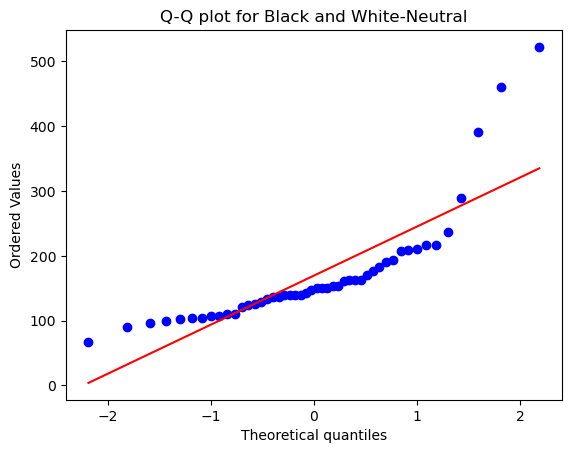

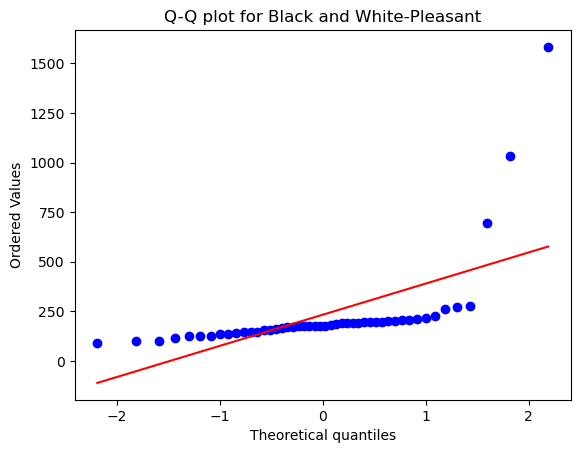

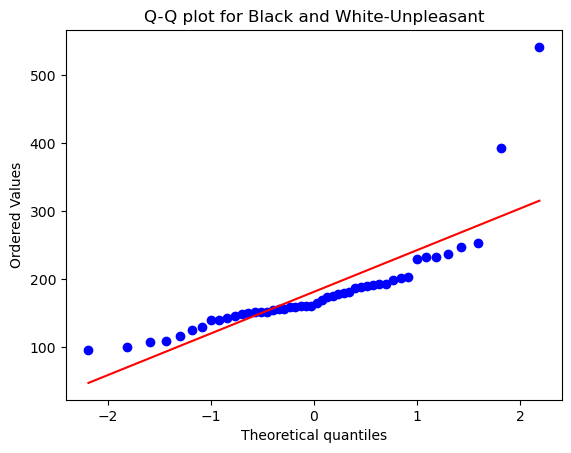

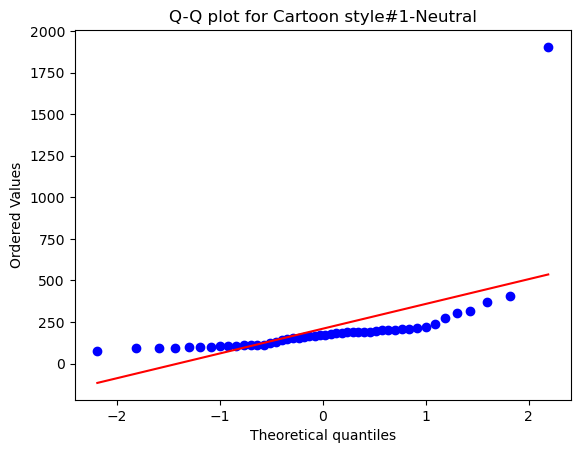

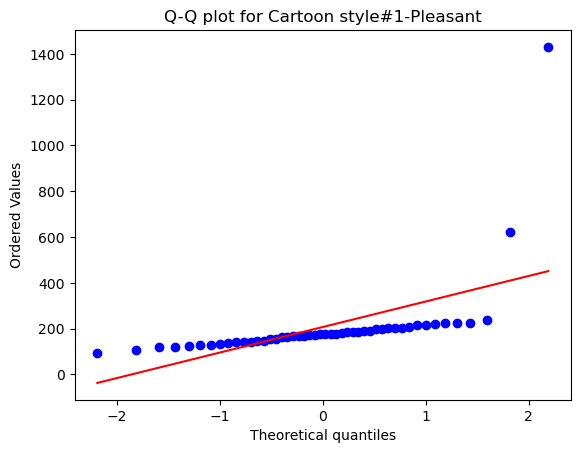

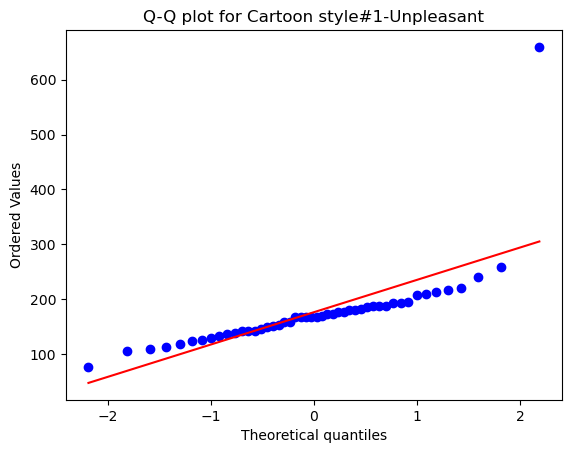

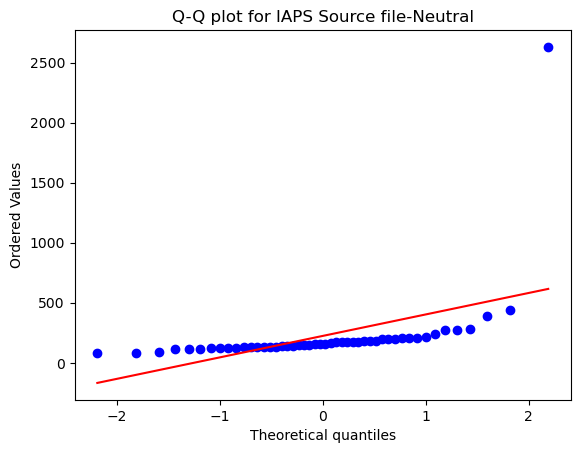

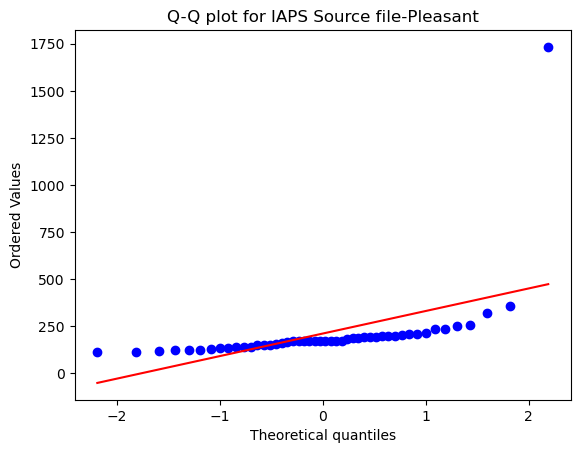

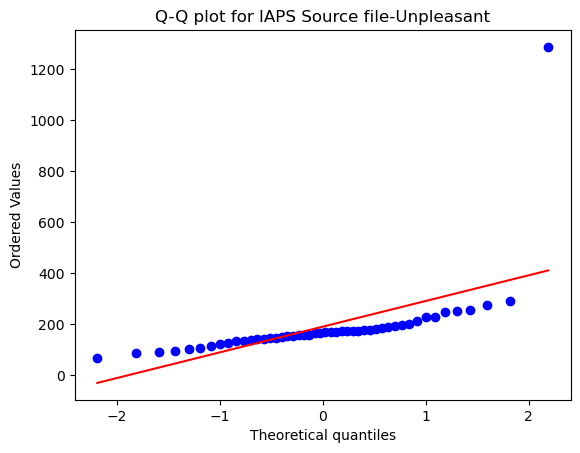

In [27]:
# Check Normality
# Use Q-Q plots to assess normality visually
for condition in avg_df['condition'].unique():
    for cond2 in avg_df['category'].unique():
        subset = avg_df[(avg_df['condition'] == condition) & (avg_df['category'] == cond2)]
        stats.probplot(subset['Fixation Duration'], dist="norm", plot=plt)
        plt.title(f"Q-Q plot for {condition}-{cond2}")
        plt.show()

In [29]:
# Run Two-Way Repeated Measures ANOVA on Fixation Duration data
aovrm2 = AnovaRM(avg_df, 'Fixation Duration', 'subj', within=['condition', 'category'],)
res2 = aovrm2.fit()

# Output the results
print(res2.summary())

                      Anova
                   F Value Num DF  Den DF  Pr > F
-------------------------------------------------
condition           0.3911 2.0000  94.0000 0.6774
category            2.1908 2.0000  94.0000 0.1175
condition:category  2.1514 4.0000 188.0000 0.0761



In [35]:
# Assuming avg_df is already defined and structured correctly
# Example structure of avg_df:
# avg_df = pd.DataFrame({
#     'category': ['A', 'A', 'B', 'B', ...],
#     'condition': ['X', 'Y', 'X', 'Y', ...],
#     'fixation_duration': [1.2, 1.5, 1.1, 1.3, ...]
# })

# Get unique categories and conditions
categories = avg_df['category'].unique()
conditions = avg_df['condition'].unique()

# Initialize a list to store results
results = []

# Perform repeated measures t-tests
for category in categories:
    for i in range(len(conditions)):
        for j in range(i + 1, len(conditions)):
            condition1 = conditions[i]
            condition2 = conditions[j]
            
            # Filter data for the current category and conditions
            data1 = avg_df[(avg_df['category'] == category) & (avg_df['condition'] == condition1)]['Fixation Duration']
            data2 = avg_df[(avg_df['category'] == category) & (avg_df['condition'] == condition2)]['Fixation Duration']
            
            # Perform t-test
            t_stat, p_value = ttest_rel(data1, data2)
            
            # Store the result
            results.append({
                'category': category,
                'condition1': condition1,
                'condition2': condition2,
                't_stat': t_stat,
                'p_value': p_value
            })

# Convert results to DataFrame for better readability
conditions_within_category_results_df = pd.DataFrame(results)

# Print the results
print(conditions_within_category_results_df)

     category       condition1        condition2    t_stat   p_value
0     Neutral  Black and White   Cartoon style#1 -1.270267  0.210242
1     Neutral  Black and White  IAPS Source file -1.202627  0.235144
2     Neutral  Cartoon style#1  IAPS Source file -0.699141  0.487910
3    Pleasant  Black and White   Cartoon style#1  1.857643  0.069491
4    Pleasant  Black and White  IAPS Source file  0.997919  0.323429
5    Pleasant  Cartoon style#1  IAPS Source file -0.218615  0.827897
6  Unpleasant  Black and White   Cartoon style#1  0.848957  0.400208
7  Unpleasant  Black and White  IAPS Source file -0.572631  0.569624
8  Unpleasant  Cartoon style#1  IAPS Source file -1.074146  0.288241


In [44]:
# Assuming avg_df is already defined and structured correctly
# Example structure of avg_df:
# avg_df = pd.DataFrame({
#     'category': ['A', 'A', 'B', 'B', ...],
#     'condition': ['X', 'Y', 'X', 'Y', ...],
#     'fixation_duration': [1.2, 1.5, 1.1, 1.3, ...]
# })

# Get unique categories and conditions
categories = avg_df['category'].unique()
conditions = avg_df['condition'].unique()

# Initialize a list to store results
results = []

# Perform repeated measures t-tests
for condition in conditions:
	for i in range(len(categories)):
		for j in range(i + 1, len(categories)):
			category1 = categories[i]
			category2 = categories[j]
			
			# Filter data for the current condition and categories
			data1 = avg_df[(avg_df['condition'] == condition) & (avg_df['category'] == category1)]['Fixation Duration']
			data2 = avg_df[(avg_df['condition'] == condition) & (avg_df['category'] == category2)]['Fixation Duration']
			
			# Perform t-test
			t_stat, p_value = ttest_rel(data1, data2)
			
			# Store the result
			results.append({
				'condition': condition,
				'category1': category1,
				'category2': category2,
				't_stat': t_stat,
				'p_value': p_value
			})

# Convert results to DataFrame for better readability
categories_within_condition_results_df = pd.DataFrame(results)

# Print the results
print(categories_within_condition_results_df)

          condition category1   category2    t_stat   p_value
0   Black and White   Neutral    Pleasant -2.053962  0.045565
1   Black and White   Neutral  Unpleasant -0.952668  0.345632
2   Black and White  Pleasant  Unpleasant  1.862363  0.068810
3   Cartoon style#1   Neutral    Pleasant  0.183907  0.854878
4   Cartoon style#1   Neutral  Unpleasant  1.207878  0.233137
5   Cartoon style#1  Pleasant  Unpleasant  1.697981  0.096124
6  IAPS Source file   Neutral    Pleasant  0.608481  0.545798
7  IAPS Source file   Neutral  Unpleasant  1.107710  0.273624
8  IAPS Source file  Pleasant  Unpleasant  1.430894  0.159076


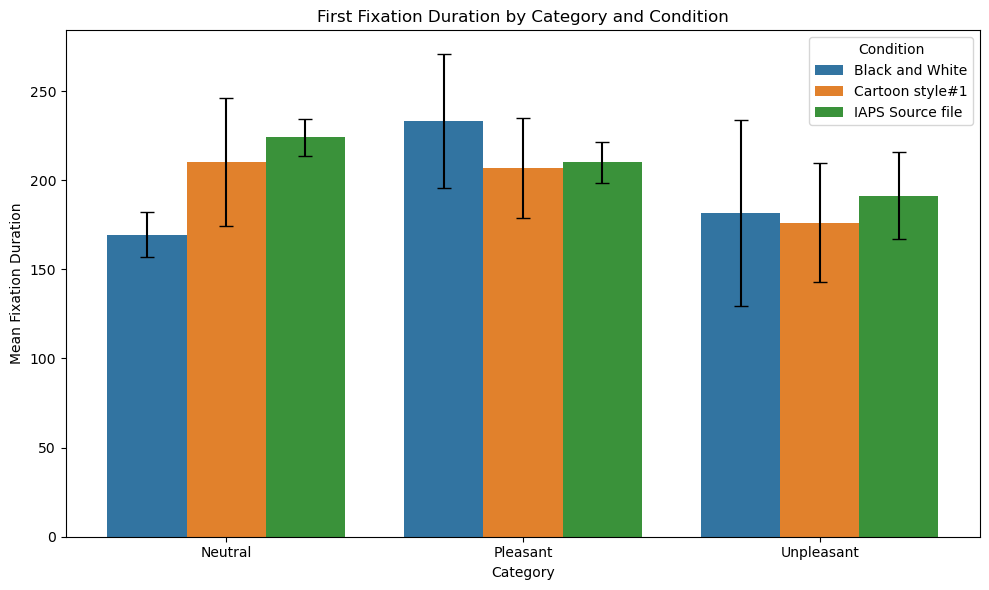

In [43]:
# Calculate means and SEMs
summary_df = avg_df.groupby(['category', 'condition']).agg(
    mean_fixation_duration=('Fixation Duration', 'mean'),
    sem_fixation_duration=('Fixation Duration', 'sem')
).reset_index()

# Create the bar plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x='category', 
    y='mean_fixation_duration', 
    hue='condition', 
    data=summary_df, 
    capsize=0.1
)

# Add error bars
for container in ax.containers:
    ax.bar_label(container, fmt='')

for i, bar in enumerate(ax.patches):
    row = summary_df.iloc[i]
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height()
    yerr = row['sem_fixation_duration']
    
    plt.errorbar(
        x=x, 
        y=y, 
        yerr=yerr, 
        fmt='none', 
        c='black', 
        capsize=5
    )
    
# Customize the plot
plt.title('First Fixation Duration by Category and Condition')
plt.xlabel('Category')
plt.ylabel('Mean Fixation Duration')
plt.legend(title='Condition')

# Show the plot
plt.tight_layout()
plt.show()

# Total Dwell Time
[ ] create an AOI of the entire image